# INTRODUCE THE ISSUE AND BACKGROUND

In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in data from NYC open data portal
df_raw = pd.read_csv('https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD')

## PART 1: Data Cleaning

1. Rename columns and remove those which are unlikely to be useful
2. Round latitude and longitude to 2 decimals to use as a feature
3. Remove 23 records where borough is not recorded
4. Convert date columns to datetime
5. Drop 5539 restaurant who've never received an A, B, or C letter grade, since we're only interested in predicting letter grades. Generally these restaurants have pending or provisional grades
6. Narrow down to a subset of INSPECTION TYPE including: 1) "Cycle Inspection / Re-inspection", 2) "Pre-permit (Operational) / Re-inspection", 3) "Pre-permit (Operational) / Initial Inspection", and 4) "Cycle Inspection / Reopening Inspection". In total, there are 32 inspection types, but only 15 give letter grades. Of those 15, only 6 give ABC grades. Only 2, (1 & 2 above) give a full distribution of A's B's and C's. We include 3 & 4 from the above list because initial inspection grades and reopening inspections (i.e. after a mandated shutdown) may be predictive of later grades
7. Remove the latest inspection grade for each restaurant. This will be used as the target variable. All previous inspections will be used as features

In [7]:
# 1. Rename columns and remove unnecessary ones

# Rename
df_raw.rename(
    columns= {
        'CAMIS':'ID',
        'DBA':'NAME',
        'ZIPCODE':'ZIP',
        'CUISINE DESCRIPTION':'CUISINE',
        'Latitude':'LAT',
        'Longitude':'LON'
    },
    inplace=True
)

# Drop useless columns
df_raw.drop(['BUILDING', 'PHONE', 'RECORD DATE', 'BIN', 'BBL'], axis=1, inplace=True)

# 2. Round off LAT/LON to use as feature
df_raw['LAT'] = df_raw['LAT'].round(2)
df_raw['LON'] = df_raw['LON'].round(2)

# 3. Drop records where boro = 0
df_raw = df_raw[df_raw['BORO'] != '0']

# 4. Convert date columns to datetime
df_raw[['INSPECTION DATE','GRADE DATE']] = df_raw[['INSPECTION DATE','GRADE DATE']].apply(pd.to_datetime)

# 5. Get rid of restaurants that have never received a letter grade
graded = df_raw[df_raw['GRADE'].isin(['A','B','C'])]['ID'].drop_duplicates()
df_raw[df_raw['ID'].isin(graded)]

# # Only look at re-inspections
# df_raw = df_raw.query('`INSPECTION TYPE` == "Cycle Inspection / Re-inspection" ')

# 6. Keep 4 inspection types that give letter grades or are useful predictors
inspection_type_keep = [
    'Pre-permit (Operational) / Re-inspection', 
    "Cycle Inspection / Re-inspection", 
    'Cycle Inspection / Reopening Inspection', 
    'Pre-permit (Operational) / Initial Inspection'
    ]
df_raw = df_raw[df_raw['INSPECTION TYPE'].isin(inspection_type_keep)]

# 7. Split latest review from all previous reviews. Lateset will be target variable

# Get max version mv (but only where the inspection type is re-inspection)
mv = pd.merge(df_raw[['ID', 'GRADE DATE']], df_raw[(df_raw['GRADE'].isin(['A','B','C'])) & (df_raw['INSPECTION TYPE'].isin(inspection_type_keep[0:2]))].groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID', 'GRADE DATE']).rename(columns={'GRADE DATE':'mv'}).drop_duplicates()

# Self join df_raw to max version to create column with max grade date
df_raw = pd.merge(df_raw, mv, how='left', on='ID', suffixes=['','_mv'])

# Latest review is when grade date == mv. Otherwise it's a previous review
df_latest_review = df_raw.query('`GRADE DATE` == mv')[['ID','GRADE','mv']].drop_duplicates()
df_prev_reviews = df_raw.query('`GRADE DATE` != mv').drop_duplicates()

## PART 2: Feature engineering

In this section we create features from the existing data and collapse the dataset down to 1 row per restaurant. Each of the new features is described below:
* n_inspections: The number of distinct inspections each restaurant has gone through prior to their latest one
* avg_scores: Scores are generated based on the number and severity of violations on each inspection. Here we take the average scores from across a restaurant's previous inspections
* n_violations: The total number of violations from all previous inspections
* no_violation_inspection: The number of times a restaurant has had an inspection without any violations
* closed_by_DOHMH: The number of times a restaurant has been closed by the department as a result of an inspection
* reopened: The number of times a restaurant has been reopened after a forced closure
* n_critical: The number of critical violations from all previous inspections
* n_a_grade: The number of A grades received in the past (multiplied by 100 and divided by n_inspections) 
* n_b_grade: The number of B grades received in the past (multiplied by 100 and divided by n_inspections)
* n_c_grade: The number of C grades received in the past (multiplied by 100 and divided by n_inspections)
* first_grade: The earliest recorded A/B/C grade for each restaurant
* penult_grade: The penultimate grade before the latest grade used as the target variable (100 if A else 0)
* 105 dummy variables - 1 for each violation type with values of the number of times each restaurant has committed each violation
* violations_per_inspection: The number of violations per inspection per restaurant
* critical_violations_per_inspection: The number of critical violations per inspection per restaurant
* CATEGORY: The 82 restaurant types are collapsed into fewer categories 
* STREET_BORO: A combination of street name and borough
* CATEGORY BORO: a combination of category and borough
* CATEGORY STREET BORO: a combination of category, street name, and borough
* CUISINE STREET BORO: a combination of cuisine, street name, and borough
* CATEGORY CENSUS TRACT: a combination of category and census tract
* CUISINE CENSUS TRACT: a combination of cuisine and census tract
* CUISINE BORO: a combination of cuisine and borough


In [16]:
# Create features
n_inspections = df_prev_reviews.groupby('ID')['INSPECTION DATE'].nunique().rename('n_inspections')
avg_scores = df_prev_reviews.groupby(['ID', 'INSPECTION DATE'])['SCORE'].mean().reset_index().groupby('ID')['SCORE'].mean().rename('avg_score')
n_violations = df_prev_reviews.query('ACTION == "Violations were cited in the following area(s)."').groupby('ID')['ACTION'].count().rename('n_violations')
no_violation_inspection = df_prev_reviews.query('ACTION == "No violations were recorded at the time of this inspection."').groupby('ID')['ACTION'].count().rename('clean_inspections')
closed_by_DOHMH = df_prev_reviews.query('ACTION == "Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed."').groupby('ID')['ACTION'].count().rename('shutdowns')
reopened = df_prev_reviews.query('ACTION == "Establishment re-opened by DOHMH."').groupby('ID')['ACTION'].count().rename('reopened_count')
n_critical = df_prev_reviews.query('`CRITICAL FLAG` == "Critical" ').groupby('ID')['CRITICAL FLAG'].count().rename('n_critical_violations')
n_a_grade = df_prev_reviews.query('`GRADE` == "A" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_A_grades')
n_b_grade = df_prev_reviews.query('`GRADE` == "B" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_B_grades')
n_c_grade = df_prev_reviews.query('`GRADE` == "C" ').groupby(['ID'])['GRADE DATE'].nunique().rename('n_C_grades')
first_grade = df_prev_reviews.merge(df_prev_reviews[df_prev_reviews['GRADE'].isin(['A','B','C'])].groupby('ID')['GRADE DATE'].min().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].groupby('ID')['GRADE'].min().rename('first_grade')
# penult_grade = pd.merge(df_prev_reviews, df_prev_reviews.groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].groupby('ID')['GRADE'].min().rename('penult_grade')
penult_grade = pd.merge(df_prev_reviews, df_prev_reviews.groupby('ID')['GRADE DATE'].max().reset_index(), on=['ID','GRADE DATE'])[['ID','GRADE']].dropna().groupby('ID')['GRADE'].min().rename('penult_grade')
# critical_violations_latest =
# critical_violations_first = 

# This will be target variable
latest_grade = df_latest_review.groupby('ID')['GRADE'].max().rename('latest_grade')

# Create dummy features for violation types
dummies = pd.get_dummies(df_prev_reviews[['ID', 'VIOLATION CODE']])
dummy_sums = dummies.groupby('ID')[list(dummies.columns[1:])].sum()

# Aggregate to each restaurant by merging categorical features with engineered features 
cat = df_raw[['ID','BORO','STREET','ZIP','CUISINE','LAT','LON','Community Board','Council District','Census Tract','NTA']].drop_duplicates()
# Merge features on ID
merged = pd.merge(cat, n_inspections, on='ID', how='left')\
    .merge(avg_scores, on='ID', how='left')\
    .merge(n_violations, on='ID', how='left')\
    .merge(no_violation_inspection, on='ID', how='left')\
    .merge(reopened, on='ID', how='left')\
    .merge(n_critical, on='ID', how='left')\
    .merge(n_a_grade, on='ID', how='left')\
    .merge(n_b_grade, on='ID', how='left')\
    .merge(n_c_grade, on='ID', how='left')\
    .merge(latest_grade, on='ID', how='left')\
    .merge(first_grade, on='ID', how='left')\
    .merge(closed_by_DOHMH, on='ID', how='left')\
    .merge(penult_grade, on='ID', how='left')\
    .merge(dummy_sums, on='ID',how='left')

# Create the rest of the features
merged['violations_per_inspection'] = merged['n_violations'] / merged['n_inspections']
merged['critical_violations_per_inspection'] = merged['n_critical_violations'] / merged['n_inspections']

# Collapse cuisine into fewer categories
cuisine_category = {
    'Caribbean':'Other', 
    'Hamburgers':'Fast', 
    'Chinese':'East Asian', 
    'Pizza':'Fast', 
    'Italian':'South European', 
    'Polish':'Eastern European',       
    'Japanese':'East Asian', 
    'Donuts':'Dessert', 
    'Chicken':'Fast', 
    'Spanish':'South European', 
    'Coffee/Tea':'Cafe', 
    'Indian':'South Asian',
    'American':'American', 
    'African':'African', 
    'Salads':'Healthy', 
    'Southeast Asian':'SE Asian', 
    'Korean':'East Asian',       
    'Latin American':'LATAM', 
    'Australian':'Other', 
    'Bakery Products/Desserts':'Dessert',
    'Mexican':'LATAM', 
    'Sandwiches':'Deli', 
    'Turkish':'Middle Eastern', 
    'Thai':'SE Asian', 
    'Tex-Mex':'LATAM', 
    'Ethiopian':'African',
    'Vegan':'Healthy', 
    'Irish':'Western European', 
    'Asian/Asian Fusion':'East Asian', 
    'Greek':'South European', 
    'Seafood':'Seafood',
    'Juice, Smoothies, Fruit Salads':'Healthy', 
    'Bagels/Pretzels':'Bakery',
    'Jewish/Kosher':'Deli', 
    'Frozen Desserts':'Dessert',
    'Sandwiches/Salads/Mixed Buffet':'Deli', 
    'Steakhouse':'Steakhouse', 
    'Mediterranean':'South European',
    'French':'Western European', 
    'Russian':'Eastern European', 
    'Peruvian':'LATAM', 
    'Vegetarian':'Healthy', 
    'Barbecue':'American',
    'Eastern European':'Eastern European', 
    'Bottled Beverages':'Other', 
    'Bangladeshi':'South Asian',
    'Middle Eastern':'Middle Eastern', 
    'Soups/Salads/Sandwiches':'Deli', 
    'Filipino':'SE Asian', 
    'Tapas':'South European',
    'Pakistani':'South Asian', 
    'Brazilian':'LATAM', 
    'Creole':'Other', 
    'Creole/Cajun':'Other', 
    'German':'Western European',
    'Moroccan':'Middle Eastern', 
    'Hotdogs':'Fast', 
    'Other':'Other', 
    'Soul Food':'American', 
    'Chinese/Cuban':'Other',
    'Continental':'Western European', 
    'Chinese/Japanese':'East Asian', 
    'Iranian':'Middle Eastern', 
    'Hotdogs/Pretzels':'Street',
    'Hawaiian':'Other', 
    'English':'Western European', 
    'Soups':'Deli', 
    'Afghan':'Middle Eastern', 
    'Californian':'American',
    'Pancakes/Waffles':'Breakfast', 
    'Scandinavian':'Northern European', 
    'Egyptian':'Middle Eastern', 
    'Southwestern':'LATAM',
    'Portuguese':'South European', 
    'Chilean':'LATAM', 
    'Fruits/Vegetables':'Healthy', 
    'Cajun':'Other',
    'Indonesian':'SE Asian', 
    'Not Listed/Not Applicable':'NA', 
    'Nuts/Confectionary':'Street',
    'New American':'American'
}
merged = pd.merge(merged, pd.DataFrame(cuisine_category.items(), columns=['CUISINE','CATEGORY']), on=['CUISINE'])

# Continue feature engineering
merged['STREET_BORO'] = merged['STREET'].astype('str') + merged['BORO'].astype('str')
merged['penult_grade'] = [100 if x == 'A' else 0 for x in merged['penult_grade']]
merged['n_A_grades'] = (100 * merged['n_A_grades']) / merged['n_inspections']
merged['n_B_grades'] = (100 * merged['n_B_grades']) / merged['n_inspections']
merged['n_C_grades'] = (100 * merged['n_C_grades']) / merged['n_inspections']
merged['CATEGORY BORO'] = merged['CATEGORY'] + merged['BORO']
merged['CATEGORY STREET BORO'] = merged['CATEGORY'].astype('str') + merged['STREET_BORO'].astype('str')
merged['CATEGORY CENSUS TRACT'] = merged['CATEGORY'].astype('str') + merged['Census Tract'].astype('str')
merged['CUISINE BORO'] = merged['CUISINE'].astype('str') + merged['BORO'].astype('str')
merged['CUISINE CENSUS TRACT'] = merged['CUISINE'].astype('str') + merged['Census Tract'].astype('str')
merged['CUISINE STREET BORO'] = merged['CUISINE'].astype('str') + merged['STREET_BORO'].astype('str')


# CREATE TARGET VARIABLE
merged = merged[merged['latest_grade'].isin(['A','B','C'])]
merged['latest_grade'] = ['A' if x == 'A' else 'B or C' for x in merged['latest_grade']]
# Create score for latest grade to use in target encoding
merged['latest_grade_score'] = [100 if x == 'A' else 0 for x in merged['latest_grade']]

# Fill na, get rid of restaurants with no previous inspections
merged = merged.fillna(0)
merged = merged[merged['n_inspections'] > 0].drop_duplicates()

## PART 3: Predicting Inspection Grades

We use a Random Forest Classifier because _______. 

Our target variable is bucketed into "A" or "B or C." Previous instantiations of the model showed poor results when predicting A's, B's, and C's separately in a multi-class classification. This is likely explained by 2 causes: 1) there's a large class imbalance with 77% of grades being A and only ______ percent being C, and 2) the model struggles to differentiate B's and C's from each other. When all 3 grades are present as options for the model to predict, its certainty that the observation belongs to B or C is split across the two, making A a comparatively surer bet. When B's and C's are bucketed, the model can have higher confidence that an observation is not A and classify it as such. 

The first version of this model is _______

Later we use SMOTE (synthetic minority oversampling technique) to _____

In [17]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# Target Encoding using latest_grade_score
import category_encoders as ce

# Target Encoding for geo
for col in [
    'CATEGORY BORO',
    'CATEGORY STREET BORO',
    'CATEGORY CENSUS TRACT',
    'CUISINE BORO',
    'CUISINE CENSUS TRACT',
    'BORO',
    'STREET', 
    'ZIP',
    'CUISINE',
    'CATEGORY',
    'Community Board',
    'Council District',
    'Census Tract',
    'NTA', 
    'STREET_BORO', 
    'first_grade', 
    'CATEGORY',
    'CUISINE STREET BORO'
    ]:
    te = ce.TargetEncoder(cols=[col])
    te.fit(merged[col], merged['latest_grade_score'])
    merged[col] = te.transform(merged[col])

# Split out features and target
X = merged.drop(['latest_grade','ID','latest_grade_score'], axis=1)
y = merged['latest_grade']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Instantiate Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=1000, 
    min_samples_split=10,
    min_samples_leaf=1, 
    max_features='auto', 
    max_depth=50
)

# Fit RF to training data
rf.fit(X_train, y_train)

# Predict on testing data
y_pred = rf.predict(X_test)

# Evaluate Results
cr = classification_report(y_test, y_pred)
print(cr)



              precision    recall  f1-score   support

           A       0.86      0.94      0.90      1900
      B or C       0.70      0.46      0.56       552

    accuracy                           0.83      2452
   macro avg       0.78      0.70      0.73      2452
weighted avg       0.82      0.83      0.82      2452



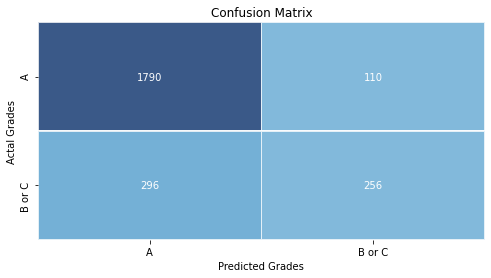

In [18]:
import matplotlib as mpl

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['A', 'B or C'], 
                     columns = ['A', 'B or C'])

cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=cmap, linewidths=.5, cbar=False, alpha=0.8)
plt.title('Confusion Matrix')
plt.ylabel('Actal Grades')
plt.xlabel('Predicted Grades')
plt.show()

In [19]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, stratify=y)

# SMOTE training data only
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not majority')
X_smote, y_smote = smote.fit_sample(X_train_smote, y_train_smote)

# Fit on training data
rf_smote = RandomForestClassifier(
    n_estimators=750, 
    min_samples_split=25,
    min_samples_leaf=3, 
    max_features='auto',
    max_depth=25
)
# rf = BalancedRandomForestClassifier(n_estimators=1000)
rf_smote.fit(X_smote, y_smote)

# Predict on testing data
y_pred_smote = rf_smote.predict(X_test_smote)

# Evaluate Results
cr_smote = classification_report(y_test_smote, y_pred_smote)
print(cr_smote)


              precision    recall  f1-score   support

           A       0.90      0.88      0.89      1900
      B or C       0.61      0.67      0.64       552

    accuracy                           0.83      2452
   macro avg       0.75      0.77      0.76      2452
weighted avg       0.84      0.83      0.83      2452



In [ ]:
# n_estimators = [100]
# max_features = ['auto','sqrt','log2']
# max_depth = [10, 50, np.nan]
# min_samples_split = [2, 20]
# min_samples_leaf = [2,25,50]

# grid_param = {
#     'n_estimators':n_estimators,
#     'max_features':max_features,
#     'max_depth':max_depth,
#     'min_samples_split':min_samples_split,
#     'min_samples_leaf':min_samples_leaf
# }

# from sklearn.model_selection import RandomizedSearchCV
# rf_grid = RandomizedSearchCV(
#     estimator=RandomForestClassifier(),
#     param_distributions=grid_param,
#     n_iter=10,
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )
# rf_grid.fit(X, y)
# print(rf_grid.best_params_)
# print(rf_grid.best_score_)


In [ ]:
# n_estimators = [500, 1000, 2500]
# max_features = ['auto','sqrt','log2']
# max_depth = [10, 35, 50, np.nan]
# min_samples_split = [2, 10, 20]
# min_samples_leaf = [1,2,10,25,50]

# Xx, yy = smote.fit_sample(X, y)
# rf_grid = RandomizedSearchCV(
#     estimator=rf_smote,
#     param_distributions=grid_param,
#     n_iter=50,
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )
# rf_grid.fit(Xx, yy)
# print(rf_grid.best_params_)
# print(rf_grid.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'n_estimators': 5000, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}
0.8241393046431013


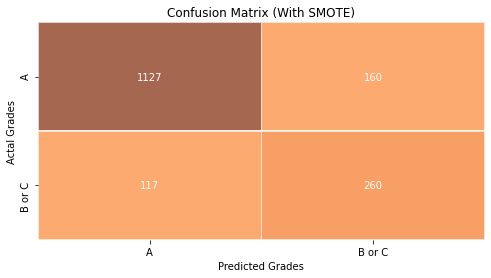

In [ ]:
import matplotlib as mpl

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test_smote, y_pred_smote)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['A', 'B or C'], 
                     columns = ['A', 'B or C'])

cmap = mpl.cm.Oranges(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

#Plotting the confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=cmap, linewidths=.5, cbar=False, alpha=0.7)
plt.title('Confusion Matrix (With SMOTE)')
plt.ylabel('Actal Grades')
plt.xlabel('Predicted Grades')
plt.show()

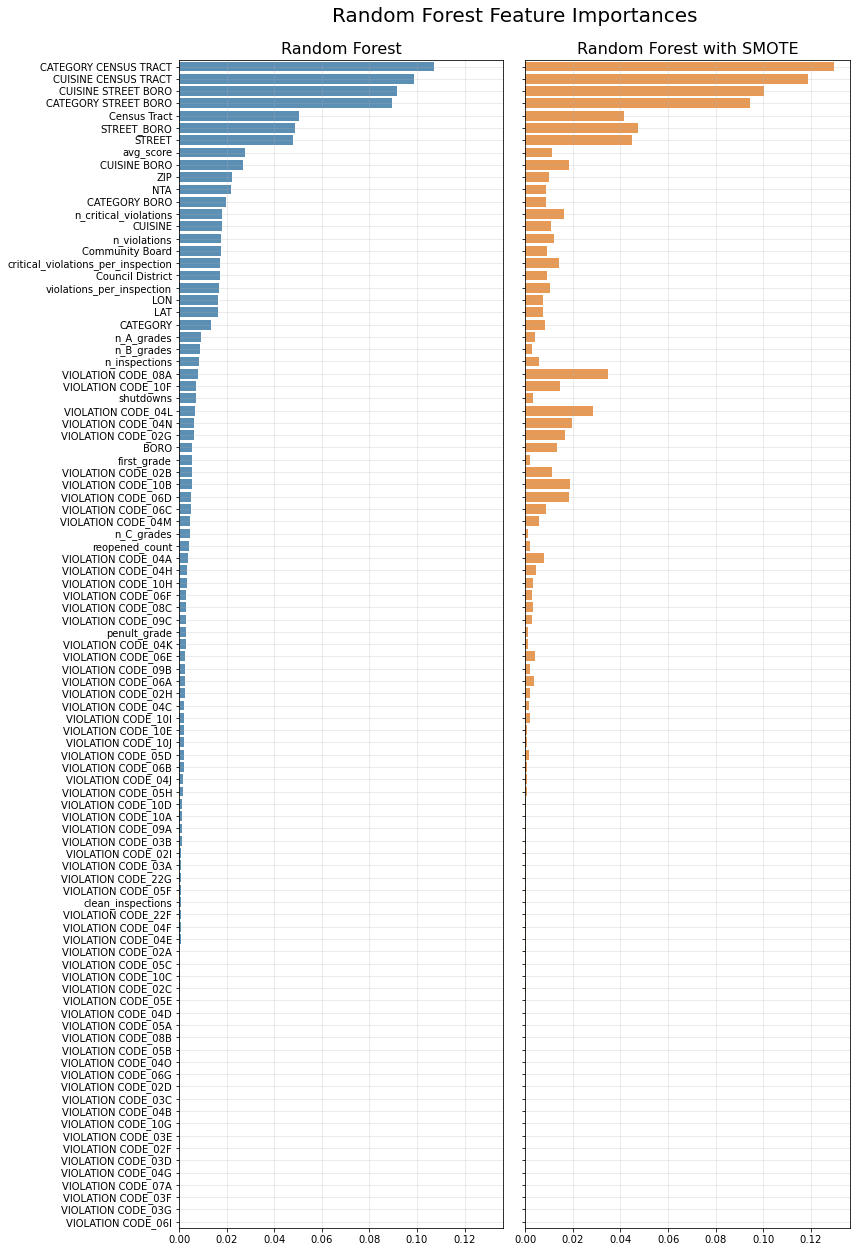

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,17), sharex=True)
importances_rf = pd.Series(rf.feature_importances_, index=X_test.columns).sort_values()
importances_rf_smote = pd.Series(rf_smote.feature_importances_, index=X_test_smote.columns).sort_values()
sns.barplot(
    data=importances_rf.reset_index().sort_values(by=0, ascending=False),
    x=0,
    y='index',
    ax=ax[0],
    color='tab:blue',
    alpha=0.8
)
sns.barplot(
    data=importances_rf_smote[importances_rf.sort_values(ascending=False).index].reset_index(),
    x=0,
    y='index',
    ax=ax[1],
    color='tab:orange',
    alpha=0.8
)
ax[0].set_title('Random Forest', fontsize=16)
ax[1].set_title('Random Forest with SMOTE', fontsize=16)
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].grid(True, which='major', axis='both', alpha=0.3, zorder=0)
ax[1].grid(True, which='major', axis='both', alpha=0.3, zorder=0)
ax[1].set_yticklabels(['']*len([item.get_text() for item in ax[1].get_yticklabels()]))
plt.tight_layout()
plt.suptitle('Random Forest Feature Importances', y=1.02, x=0.6, fontsize=20)
plt.show()


Text(0.5, 1.0, 'ROC Curve: Random Forest Predicting B or C Inspection Grades')

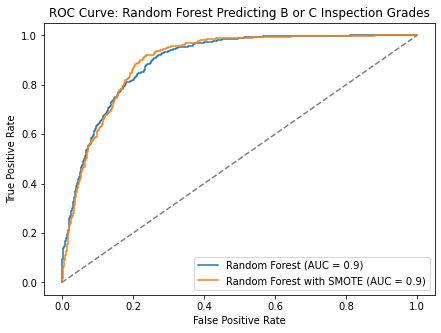

In [ ]:
y_pred_prob_sm = rf_smote.predict_proba(X_test_smote)[:,1]
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test_smote, y_pred_prob_sm, pos_label='B or C')
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='B or C')
fig, ax = plt.subplots(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.plot(fpr, tpr, label='Random Forest (AUC = ' + str(round(roc_auc_score(y_test, y_pred_prob),2)) + ')')
plt.plot(fpr_sm, tpr_sm, label='Random Forest with SMOTE (AUC = ' + str(round(roc_auc_score(y_test_smote, y_pred_prob_sm),2)) + ')')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Predicting B or C Inspection Grades')